In this notebook, we will be looking at the ability of a few different methods of assigning p-values to genes (closest gene, min p, and VEGAS2v2) on the ability to recover known genes at given p-value threshold without any network information.

# Load Gold Standard Gene Sets

In [45]:
# Load WTCCC disease gold standards
WTCCC_disease_codes = {'BipolarDisorder':'BD',
                       'CrohnsDisease':'CD',
                       'CoronaryArteryDisease':'CAD',
                       'Hypertension':'HT',
                       'RheumatoidArthritis':'RA',
                       'Type1Diabetes':'T1D',
                       'Type2Diabetes':'T2D'}
WTCCC_gold_standards = {}

f = open('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/WTCCC_DisGeNET_Gold_Standards.txt')
lines = f.read().splitlines()
f.close()

for line in lines:
    line_split = line.split('\t')
    WTCCC_gold_standards[WTCCC_disease_codes[line_split[0]]] = line_split[1:]

In [46]:
# Load Alzheimers disease gold standards
Alzheimers_disease_codes = {'DisGeNET Gold Standard':'ALZ',
                            'Expression Gold Standard':'ALZ_EXP'}
ALZ_gold_standards = {}

g = open('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Data/IGAP/Alzheimers_Gold_Standard_sets.txt')
lines = g.read().splitlines()
g.close()
for line in lines:
    line_split = line.split('\t')
    ALZ_gold_standards[Alzheimers_disease_codes[line_split[0]]] = line_split[1:]

# Get gene P-value assignment numbers

In [50]:
import numpy as np
import os
import pandas as pd
from scipy.stats import hypergeom

In [51]:
wd = '/cellar/users/jkhuang/Data/nosnap/Projects/NBGWAS/snp2gene/'
pval_thresh = 1e-6

In [58]:
# Get all gold standard recovery numbers for each method
snp2gene_eval = []
for fn in os.listdir(wd):
    if fn.endswith('.csv'):
        # Get snp2gene method stats
        fn_split = fn.split('_')
        disease = fn_split[0]
        if 'VEGAS2' not in fn:
            method = ' '.join(fn_split[2:4]).title()
        else:
            method = ''.join(fn_split[2:4])
        window = int(fn_split[-1].split('.')[0][:-2])
        
        # Load gene pvalues from method
        pval_table = pd.read_csv(wd+fn, sep='\t')
        # Get total genes
        all_genes = set(pval_table['Gene'])
        if disease != 'ALZ':
            gold_std = set(WTCCC_gold_standards[disease])
            # Get the number of all genes also in gold standard
            all_gs_genes = all_genes.intersection(gold_std)
            # Get genes with p-values below threshold
            sig_genes = set(pval_table[pval_table['TopSNP P-Value'] < pval_thresh]['Gene'])
            # Get all significant genes also in gold standard
            sig_gs_genes = sig_genes.intersection(gold_std)
            # Get p-value of hypergeometric test
            hypergeom_p = hypergeom(len(all_genes), len(all_gs_genes), len(sig_genes)).pmf(len(sig_gs_genes))
            # Get log10(p-value)
            log_p = -np.log10(hypergeom_p)
            snp2gene_eval.append([disease, method, window, 
                                  len(all_genes), len(all_gs_genes), 
                                  len(sig_genes), len(sig_gs_genes),
                                  hypergeom_p, log_p])
        else:
            for disease in ALZ_gold_standards.keys():
                gold_std = set(ALZ_gold_standards[disease])
                # Get the number of all genes also in gold standard
                all_gs_genes = all_genes.intersection(gold_std)
                # Get genes with p-values below threshold
                sig_genes = set(pval_table[pval_table['TopSNP P-Value'] < pval_thresh]['Gene'])
                # Get all significant genes also in gold standard
                sig_gs_genes = sig_genes.intersection(gold_std)
                # Get p-value of hypergeometric test
                hypergeom_p = hypergeom(len(all_genes), len(all_gs_genes), len(sig_genes)).pmf(len(sig_gs_genes))
                # Get log10(p-value)
                log_p = -np.log10(hypergeom_p)
                snp2gene_eval.append([disease, method, window, 
                                      len(all_genes), len(all_gs_genes), 
                                      len(sig_genes), len(sig_gs_genes),
                                      hypergeom_p, log_p])
        
snp2gene_eval_table = pd.DataFrame(snp2gene_eval, columns = ['Disease', 'SNP2Gene Method', 'Window (kb)', 
                                                             'Total Genes', 'GS Genes', 'Sig Genes', 'Sig GS Genes', 
                                                             'Hypergeometric P', '-log(P)'])
    

# Plot gold standard assignment performance of different methods

In [116]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

In [118]:
diseases = list(set(snp2gene_eval_table['Disease']))

In [119]:
# Build disease to color map
diseases = WTCCC_gold_standards.keys()
diseases.sort()
diseases = diseases + sorted(ALZ_gold_standards.keys())
colors = sns.color_palette('hls', len(diseases))

disease_cmap = {}
for i in range(len(diseases)):
    disease_cmap[diseases[i]] = colors[i]

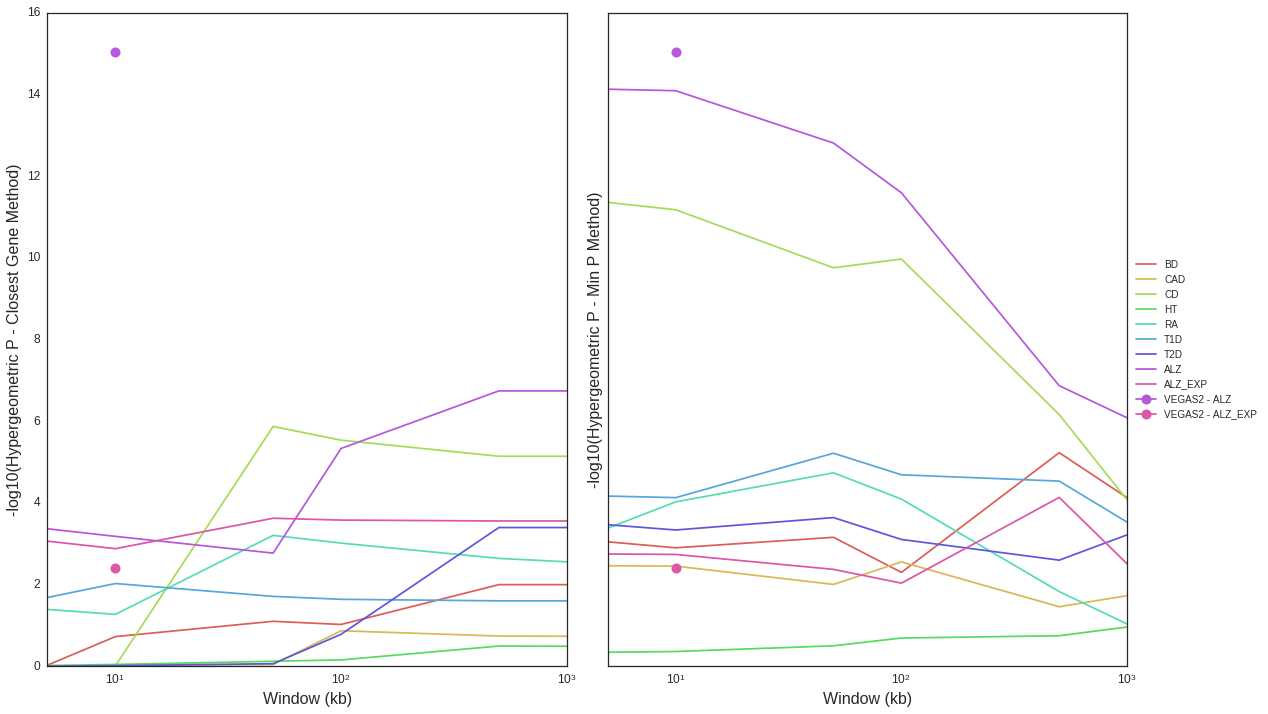

In [122]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,10), sharey=True)

# Plot other methods
for disease in diseases:
    for method in ['Closest Gene', 'Min P']:
        table_slice = snp2gene_eval_table[(snp2gene_eval_table['Disease']==disease) & 
                                          (snp2gene_eval_table['SNP2Gene Method']==method)].sort_values(by='Window (kb)')
        x = list(table_slice['Window (kb)'])
        y = list(table_slice['-log(P)'])
        if method == 'Closest Gene':
            ax1.plot(x, y, color=disease_cmap[disease], label=disease)
        else:
            ax2.plot(x, y, color=disease_cmap[disease], label=disease)

# Plot VEGAS2 Results
VEGAS2_ALZ_y = float(snp2gene_eval_table[(snp2gene_eval_table['Disease']=='ALZ') & 
                                         (snp2gene_eval_table['SNP2Gene Method']=='VEGAS2v2')]['-log(P)'])
ax1.plot([10], [VEGAS2_ALZ_y], marker='o', markersize=10, color=disease_cmap['ALZ'], label='VEGAS2 - ALZ')
ax2.plot([10], [VEGAS2_ALZ_y], marker='o', markersize=10, color=disease_cmap['ALZ'], label='VEGAS2 - ALZ')

VEGAS2_ALZ_EXP_y = float(snp2gene_eval_table[(snp2gene_eval_table['Disease']=='ALZ_EXP') & 
                                             (snp2gene_eval_table['SNP2Gene Method']=='VEGAS2v2')]['-log(P)'])
ax1.plot([10], [VEGAS2_ALZ_EXP_y], marker='o', markersize=10, color=disease_cmap['ALZ_EXP'], label='VEGAS2 - ALZ_EXP')
ax2.plot([10], [VEGAS2_ALZ_EXP_y], marker='o', markersize=10, color=disease_cmap['ALZ_EXP'], label='VEGAS2 - ALZ_EXP')

# Plot Parameters
ax1.set_xscale('log')
ax1.xaxis.set_tick_params(labelsize=12)
ax1.set_xlim((5, 1000))
ax1.set_xlabel('Window (kb)', fontsize=16)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.set_ylabel('-log10(Hypergeometric P - Closest Gene Method)', fontsize=16)

ax2.set_xscale('log')
ax2.xaxis.set_tick_params(labelsize=12)
ax2.set_xlim((5, 1000))
ax2.yaxis.set_tick_params(labelsize=12)
ax2.set_xlabel('Window (kb)', fontsize=16)
ax2.set_ylabel('-log10(Hypergeometric P - Min P Method)', fontsize=16)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('/cellar/users/jkhuang/Data/Projects/Network_GWAS/Results/SNP2Gene_Performance_Summary.pdf', bbox_inches='tight')

In [126]:
sorted(list(set(snp2gene_eval_table['Window (kb)'])))

[5, 10, 50, 100, 500, 1000]

In [147]:
# Average -log10(P-value) across all gene sets by method and genomic distance
methods = sorted(list(set(snp2gene_eval_table['SNP2Gene Method'])))
windows = sorted(list(set(snp2gene_eval_table['Window (kb)'])))
window_labels = [repr(i)+' kb' for i in windows]
avg_table = pd.DataFrame(index = methods, columns = window_labels)
for method in methods:
    for window in windows:
        avg_score = snp2gene_eval_table[(snp2gene_eval_table['SNP2Gene Method']==method) & 
                                        (snp2gene_eval_table['Window (kb)']==window)]['-log(P)'].mean()
        avg_table.set_value(method, repr(window)+' kb', avg_score)
avg_table

,5 kb,10 kb,50 kb,100 kb,500 kb,1000 kb
Closest Gene,1.06429,1.13134,2.05859,2.43887,2.92536,2.91497
Min P,5.01219,5.0247,4.91177,4.55989,3.73017,3.03018
VEGAS2v2,NaN,8.72854,NaN,NaN,NaN,NaN
